In [1]:
from glob import glob
import pandas as pd
from scipy.stats import spearmanr, fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
import seaborn as sns

sns.set_context('talk')
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_style('whitegrid')

def p_adjust(pvalues, method='fdr_bh'):
    res = multipletests(pvalues, method=method)
    return np.array(res[1], dtype=float)

def measure_enrichment(sig_kos, modules, all_module_kos):
    enrichment_rows = list()
    for module, module_kos in modules.items():
        in_in = len(sig_kos & module_kos)  # in module and in gene set
        in_out = len(sig_kos - module_kos)  # in gene set and out of module
        out_in = len(module_kos - sig_kos)  # in module and out of gene set
        out_out = len(all_module_kos - module_kos - sig_kos)

        odds_ratio, p_value = fisher_exact([[in_in, in_out],
                                            [out_in, out_out]], alternative='greater')
        enrichment_rows.append([module, len(module_kos), in_in, in_out, out_in, out_out, odds_ratio, p_value])
    enrichment = pd.DataFrame(enrichment_rows, columns=['module', 'module_size', 'in_in', 'in_out', 'out_in', 'out_out', 'odds_ratio', 'p_value']).set_index('module').sort_values('p_value')
    enrichment['p_adj'] = p_adjust(enrichment['p_value'])
    return enrichment

# Correlate titers with KOs

## Read in data

In [2]:
meta = pd.read_csv('../../data/metadata/stool/stool_metadata.csv', index_col='SampleID')
meta = pd.concat([meta,
                  pd.read_csv('../../data/metadata/stool/stool_abx_usage.csv', index_col='SampleID'),
                  pd.read_csv('../../data/metadata/stool/stool_titers_yr1.csv', index_col='SampleID')],
                 axis=1)
meta = meta.query("`gt_2.5` == True")
meta['VR_group'] = meta['VR_group'].fillna('Not Measured')
meta = meta.sort_values(['BabyN', 'age_at_collection'])
meta = meta.loc[~pd.isna(meta['median_mmNorm'])]
meta.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
SampleID,,,,,,,,,,,,,,,,,,,,,
106_V2,Primary in Tube,69,NaN,NaN,"Box 8, F3",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_V6,Primary in Tube,121,NaN,NaN,"Box 10, C1",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_V7,Primary in Tube,158,NaN,NaN,"Box 11, C3",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_S_1,Primary in Tube,162,NaN,NaN,"Box 11, D1",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_A1,Primary in Tube,188,NaN,NaN,"Box 12, B3",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR


In [3]:
ko_abunds = pd.read_csv('../../data/stool/ko_abundance_table.rel.tsv', sep='\t', index_col=0)
ko_abunds.index = [i.replace("'", "_").replace('#', '_') for i in ko_abunds.index]
ko_abunds.columns = [i.split('.txt')[0] for i in ko_abunds.columns]
ko_abunds = ko_abunds[meta.index]
print(ko_abunds.shape)
display(ko_abunds.head())

(11048, 529)


,106_V2,106_V6,106_V7,106_S_1,106_A1,107_V2,107_V3,107_V6,107_S1,107_V7,...,264_S2F,264_V9,264_V10,264_V11,264_V12,265_V2,265_V5,265_V6,265_V8,265_S1
K00001,0.000107,0.000230,0.000334,0.000185,0.000906,4.820137e-04,0.000200,0.000760,0.000746,7.461465e-04,...,7.914440e-04,3.764422e-04,0.000187,1.659096e-04,0.000143,0.000019,0.000002,6.134967e-04,0.000217,3.267179e-04
K00002,0.000000,0.000000,0.000003,0.000002,0.000001,0.000000e+00,0.000000,0.000000,0.000002,9.658854e-07,...,2.815525e-07,6.831982e-07,0.000016,1.020476e-05,0.000007,0.000000,0.000000,0.000000e+00,0.000002,2.978285e-07
K00003,0.000066,0.000667,0.000209,0.000128,0.001472,9.958655e-05,0.000074,0.001010,0.001160,7.393853e-04,...,9.913462e-04,5.342610e-04,0.000521,6.297325e-04,0.000501,0.000054,0.000043,5.555358e-06,0.000397,6.165050e-04
K00004,0.000036,0.000002,0.000000,0.000000,0.000000,7.404204e-07,0.000004,0.000004,0.000000,7.727083e-06,...,4.645616e-06,3.415991e-07,0.000002,3.291858e-07,0.000006,0.000003,0.000049,3.703572e-07,0.000000,2.680457e-06
K00005,0.000020,0.000537,0.000064,0.000041,0.000021,1.096563e-03,0.000402,0.000136,0.000145,3.037710e-04,...,1.144511e-04,7.890940e-05,0.000201,2.011325e-04,0.000209,0.000390,0.000398,9.525587e-04,0.000120,3.154004e-04


In [4]:
in_both = set(meta.index) & set(ko_abunds.columns)
meta_matched = meta.loc[in_both]
print(meta_matched.shape)

(529, 86)


/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/2340599432.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  meta_matched = meta.loc[in_both]


In [5]:
meta_v5 = meta_matched.query("VisitCode == 'V5'")
meta_v6 = meta_matched.query("VisitCode == 'V6'")
meta_v7 = meta_matched.query("VisitCode == 'V7'")
meta_v9 = meta_matched.query("VisitCode == 'V9'")

In [6]:
meta_PCV = meta_matched.loc[~pd.isna(meta_matched['median_mmNorm_PCV'])]
meta_PCV.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
SampleID,,,,,,,,,,,,,,,,,,,,,
119_V8,Primary in Tube,420,NaN,NaN,Box9,Stool,Human Infant,MetaG,119,NaN,...,0.100649,0.060490,1.4,2.6,4.466667,0.3125,0.7500,0.7500,1.191268,NVR
234_V11,Primary in Tube,672,NaN,NaN,Box21,Stool,Human Infant,MetaG,234,NaN,...,0.041118,0.000000,0.5,0.5,0.866667,0.3125,0.3125,0.1875,0.397877,LVR
252_V8,Primary in Tube,484,NaN,NaN,Box12,Stool,Human Infant,MetaG,252,NaN,...,0.481453,0.161003,8.3,7.9,7.800000,1.3750,0.8750,0.1875,2.206405,NVR
238_S1,Primary in Tube,549,NaN,NaN,Box15,Stool,Human Infant,MetaG,238,NaN,...,0.091191,0.032536,3.5,3.5,4.800000,0.3125,0.3125,0.1875,1.012387,NVR
201_S1,Primary in Tube,177,NaN,NaN,"Box 11, F4",Stool,Human Infant,MetaG,201,NaN,...,0.392850,0.055923,3.5,3.7,4.600000,0.3125,0.7500,0.1875,1.173969,NVR


In [7]:
# The KEGG module file is not in the git repo, future users will need to find a copy of this file somewhere
modules = {line.strip().split()[0]: set(line.strip().split()[1:]) for line in open('../../../../KEGG.20210320/module_kos.tsv')}
modules = {key: value for key, value in modules.items() if len(value) >= 5}
all_module_kos = {ko for module, kos in modules.items() for ko in kos}
print(len(all_module_kos))

2208


## KO correlations

### 2 months

In [8]:
ko_abunds_v5 = ko_abunds[meta_v5.index]
ko_abunds_v5 = ko_abunds_v5.loc[(ko_abunds_v5 > 0).sum(axis=1) > ko_abunds_v5.shape[1]*.2]
ko_abunds_v5 = ko_abunds_v5.loc[ko_abunds_v5.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v5.shape)

(4416, 43)


In [9]:
v5_correlations = ko_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations.columns = ['rho', 'p_value']
v5_correlations['p_adj'] = p_adjust(v5_correlations['p_value'])
v5_correlations = v5_correlations.sort_values('p_value')
v5_correlations.head()

,rho,p_value,p_adj
K21394,-0.506484,0.000529,0.517858
K05784,0.504534,0.000561,0.517858
K02517,0.498037,0.000678,0.517858
K03327,0.488221,0.000896,0.517858
K00343,0.478707,0.001165,0.517858


In [10]:
print(len(v5_correlations.query('p_value < .05')))

378


When we do these correlations we get no significant after FDR correction. There is strong significance in the raw p-values though with 278 unadjusted p-values < .05. To take advantage of this result we will run a module enrichment test to look for enrichment of KEGG modules.

In [11]:
v5_sig_kos = set(v5_correlations.query('p_value < .05').index)
v5_enrichment = measure_enrichment(v5_sig_kos, modules, all_module_kos)
v5_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00060,10,7,371,3,2134,13.421384,0.000131,0.023278
M00144,16,9,369,7,2130,7.421603,0.000153,0.023278
M00866,11,7,371,4,2133,10.061321,0.000314,0.031791
M00913,5,3,375,2,2135,8.540000,0.026621,1.000000
M00116,9,4,374,5,2132,4.560428,0.033886,1.000000


In [12]:
v5_enrichment.to_csv('../../data/stool/ko_correlation_enrichment_V5.tsv', sep='\t')

When we do this we find 3 modules which are significantly enriched. M00060 and M00866 are the same but with 1 KO added for 866.

#### Dig into modules

In [13]:
v5_correlations.loc[set(v5_correlations.index) & modules['M00060']].sort_values('p_value')

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/3075512320.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  v5_correlations.loc[set(v5_correlations.index) & modules['M00060']].sort_values('p_value')


,rho,p_value,p_adj
K02517,0.498037,0.000678,0.517858
K02527,0.418303,0.005248,0.517858
K00912,0.397916,0.008229,0.517858
K03269,0.372244,0.013968,0.517858
K00677,0.368771,0.014958,0.517858
K00748,0.360163,0.017674,0.517858
K02536,0.331773,0.029747,0.526796
K09949,0.186440,0.231278,0.708491
K02560,-0.119450,0.445496,0.809950
K02535,-0.055270,0.724822,0.872395


In [14]:
v5_correlations.loc[set(v5_correlations.index) & modules['M00144']].sort_values('p_value')

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/136881632.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  v5_correlations.loc[set(v5_correlations.index) & modules['M00144']].sort_values('p_value')


,rho,p_value,p_adj
K00343,0.478707,0.001165,0.517858
K00338,0.420266,0.005018,0.517858
K00341,0.406222,0.006873,0.517858
K00339,0.392782,0.009177,0.517858
K13378,0.374962,0.013232,0.517858
K00342,0.373603,0.013595,0.517858
K00337,0.354878,0.019539,0.517858
K00340,0.347780,0.022301,0.517858
K00331,0.326941,0.032362,0.526796
K00330,0.279070,0.069947,0.592711


In [63]:
print('\t'.join(modules['M00144']))

K00334	K00332	K00339	K13378	K00341	K00343	K00337	K00331	K00338	K00342	K00330	K13380	K00335	K00333	K00340	K00336


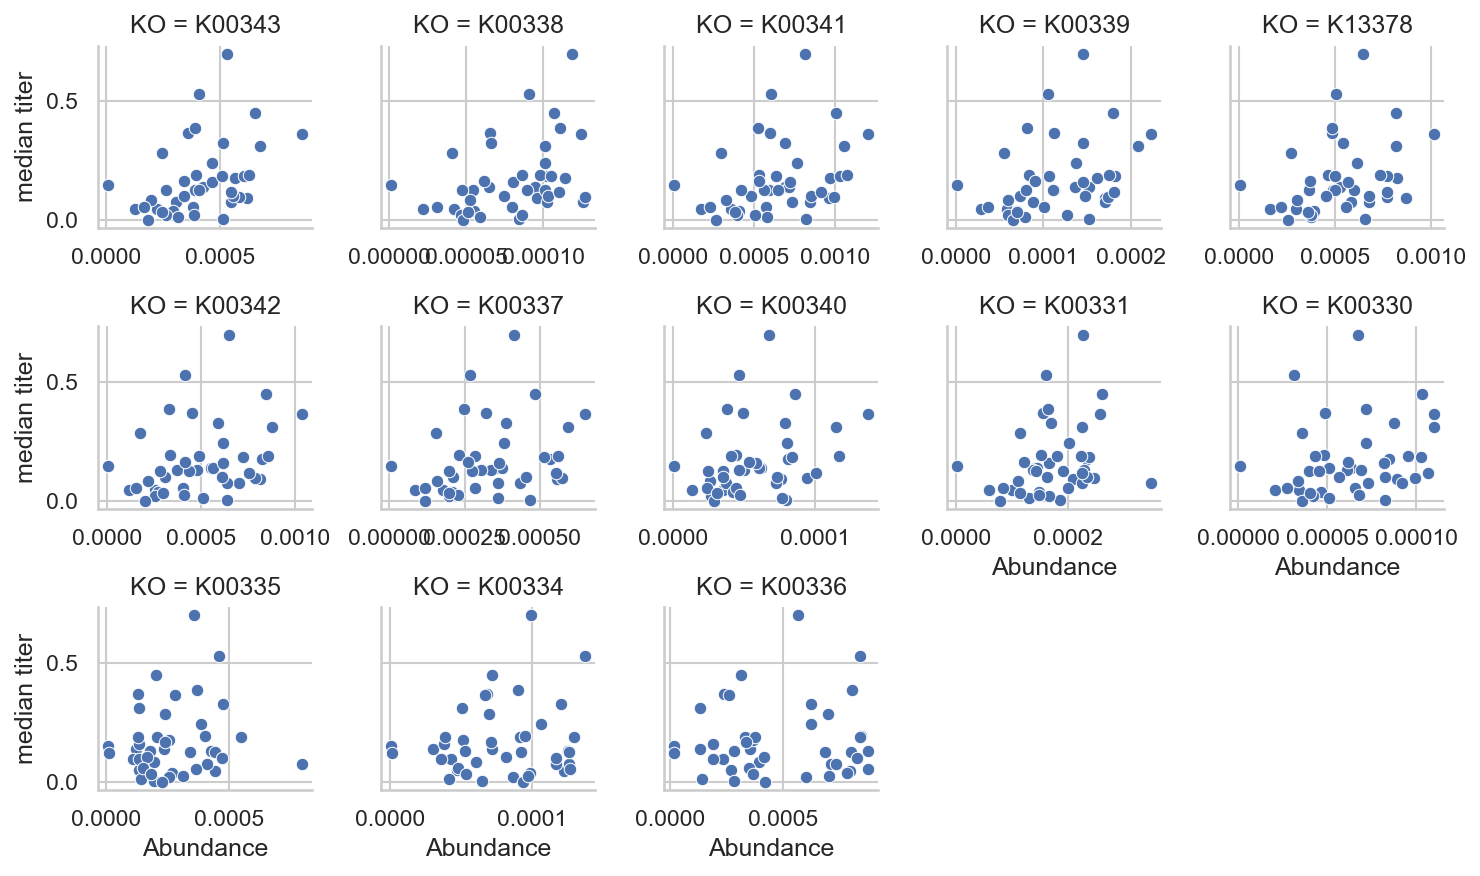

In [15]:
m00144_ko_correlations = v5_correlations.loc[[i for i in modules['M00144'] if i in v5_correlations.index]].sort_values('p_value')
m00144_ko_abunds = ko_abunds_v5.loc[m00144_ko_correlations.index].unstack().reset_index()
m00144_ko_abunds.columns = ['Sample', 'KO', 'Abundance']
m00144_ko_abunds['median titer'] = [meta_v5.loc[sample, 'median_mmNorm'] for sample in m00144_ko_abunds['Sample'].values]
g = sns.FacetGrid(m00144_ko_abunds, col="KO", col_wrap=5, height=2, sharex=False)
_ = g.map(sns.scatterplot, "Abundance", "median titer")
g

In [16]:
v5_correlations.loc[set(v5_correlations.index) & modules['M00866']].sort_values('p_value')

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/872333751.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  v5_correlations.loc[set(v5_correlations.index) & modules['M00866']].sort_values('p_value')


,rho,p_value,p_adj
K02517,0.498037,0.000678,0.517858
K02527,0.418303,0.005248,0.517858
K00912,0.397916,0.008229,0.517858
K03269,0.372244,0.013968,0.517858
K00677,0.368771,0.014958,0.517858
K00748,0.360163,0.017674,0.517858
K02536,0.331773,0.029747,0.526796
K16363,0.224212,0.148344,0.637504
K09949,0.186440,0.231278,0.708491
K02535,-0.055270,0.724822,0.872395


LPS, LPS and oxidative phosphorlyation? Is this hope?

### 4 months

In [17]:
ko_abunds_v6 = ko_abunds[meta_v6.index]
ko_abunds_v6 = ko_abunds_v6.loc[(ko_abunds_v6 > 0).sum(axis=1) > ko_abunds_v6.shape[1]*.2]
ko_abunds_v6 = ko_abunds_v6.loc[ko_abunds_v6.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v6.shape)

(4386, 45)


In [18]:
v6_correlations = ko_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm']).transpose()
v6_correlations.columns = ['rho', 'p_value']
v6_correlations['p_adj'] = p_adjust(v6_correlations['p_value'])
v6_correlations = v6_correlations.sort_values('p_value')
v6_correlations.head()

,rho,p_value,p_adj
K19129,0.396384,0.007026,0.999657
K12990,0.393856,0.007431,0.999657
K08998,0.371949,0.011873,0.999657
K20510,0.369541,0.012478,0.999657
K01430,0.364692,0.013775,0.999657


In [19]:
print(len(v6_correlations.query('p_value < .05')))

31


Many fewer significant results than at 2 months but we will still look for enrichment.

In [20]:
v6_sig_kos = set(v6_correlations.query('p_value < .05').index)
v6_enrichment = measure_enrichment(v6_sig_kos, modules, all_module_kos)
v6_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00802,5,1,30,4,2200,18.333333,0.067513,1.0
M00568,5,1,30,4,2200,18.333333,0.067513,1.0
M00649,5,1,30,4,2200,18.333333,0.067513,1.0
M00122,10,1,30,9,2195,8.129630,0.130605,1.0
M00001,30,0,31,30,2174,0.000000,1.000000,1.0


We find nothing though.

### 6 months

In [21]:
ko_abunds_v7 = ko_abunds[meta_v7.index]
ko_abunds_v7 = ko_abunds_v7.loc[(ko_abunds_v7 > 0).sum(axis=1) > ko_abunds_v7.shape[1]*.2]
ko_abunds_v7 = ko_abunds_v7.loc[ko_abunds_v7.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v7.shape)

(4330, 50)


In [22]:
v7_correlations = ko_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm']).transpose()
v7_correlations.columns = ['rho', 'p_value']
v7_correlations['p_adj'] = p_adjust(v7_correlations['p_value'])
v7_correlations = v7_correlations.sort_values('p_value')
v7_correlations.head()

,rho,p_value,p_adj
K07746,-0.400118,0.003989,0.967379
K01129,0.397176,0.004291,0.967379
K02968,0.384835,0.005789,0.967379
K11752,0.363850,0.009392,0.967379
K06994,-0.358471,0.010581,0.967379


In [23]:
print(len(v7_correlations.query('p_value < .05')))

48


Many fewer significant results than at 2 months but we will still look for enrichment.

In [24]:
v7_sig_kos = set(v7_correlations.query('p_value < .05').index)
v7_enrichment = measure_enrichment(v7_sig_kos, modules, all_module_kos)
v7_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00125,17,3,45,14,2189,10.423810,0.005018,1.0
M00911,8,2,46,6,2197,15.920290,0.011489,1.0
M00914,7,1,47,6,2197,7.790780,0.140225,1.0
M00120,12,1,47,11,2192,4.239845,0.228405,1.0
M00083,14,1,47,13,2190,3.584288,0.261140,1.0


We find nothing though.

### 1 year

In [25]:
ko_abunds_v9 = ko_abunds[meta_v9.index]
ko_abunds_v9 = ko_abunds_v9.loc[(ko_abunds_v9 > 0).sum(axis=1) > ko_abunds_v9.shape[1]*.2]
ko_abunds_v9 = ko_abunds_v9.loc[ko_abunds_v9.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v9.shape)

(4259, 42)


In [26]:
v9_correlations = ko_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations.columns = ['rho', 'p_value']
v9_correlations['p_adj'] = p_adjust(v9_correlations['p_value'])
v9_correlations = v9_correlations.sort_values('p_value')
v9_correlations.head()

,rho,p_value,p_adj
K03183,-0.507819,0.000597,0.294533
K15599,-0.505293,0.000642,0.294533
K18139,-0.500041,0.000746,0.294533
K00817,-0.495989,0.000837,0.294533
K00848,-0.494044,0.000884,0.294533


In [27]:
print(len(v9_correlations.query('p_value < .05')))

579


At one year there is a large number of significant KOs. An alarmingly large number.

In [28]:
v9_sig_kos = set(v9_correlations.query('p_value < .05').index)
v9_enrichment = measure_enrichment(v9_sig_kos, modules, all_module_kos)
v9_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00570,8,5,574,3,2075,6.024971,0.015008,1.0
M00019,6,4,575,2,2076,7.220870,0.022966,1.0
M00124,6,4,575,2,2076,7.220870,0.022966,1.0
M00060,10,5,574,5,2073,3.611498,0.045815,1.0
M00866,11,5,574,6,2072,3.008130,0.069340,1.0


But after testing for enrichment none is found.

### Following significant 2 month results

In [29]:
m00060_ko_cross_correlations_v5 = v5_correlations.loc[modules['M00060']].sort_values('p_value')
m00060_ko_cross_correlations_v5

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/2060652507.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00060_ko_cross_correlations_v5 = v5_correlations.loc[modules['M00060']].sort_values('p_value')


,rho,p_value,p_adj
K02517,0.498037,0.000678,0.517858
K02527,0.418303,0.005248,0.517858
K00912,0.397916,0.008229,0.517858
K03269,0.372244,0.013968,0.517858
K00677,0.368771,0.014958,0.517858
K00748,0.360163,0.017674,0.517858
K02536,0.331773,0.029747,0.526796
K09949,0.186440,0.231278,0.708491
K02560,-0.119450,0.445496,0.809950
K02535,-0.055270,0.724822,0.872395


In [30]:
m00060_ko_cross_correlations_v6 = v6_correlations.loc[modules['M00060']].sort_values('p_value')
m00060_ko_cross_correlations_v6

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/2514075304.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00060_ko_cross_correlations_v6 = v6_correlations.loc[modules['M00060']].sort_values('p_value')


,rho,p_value,p_adj
K00912,0.285846,0.056978,0.999657
K02517,0.206067,0.174441,0.999657
K00677,0.178201,0.241530,0.999657
K02527,0.171745,0.259284,0.999657
K00748,0.141045,0.355399,0.999657
K02535,-0.081228,0.595808,0.999657
K03269,0.073850,0.629723,0.999657
K02560,-0.062057,0.685500,0.999657
K09949,-0.023941,0.875949,0.999657
K02536,0.012846,0.933252,0.999657


In [31]:
m00060_ko_cross_correlations_v7 = v7_correlations.loc[modules['M00060']].sort_values('p_value')
m00060_ko_cross_correlations_v7

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/524265188.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00060_ko_cross_correlations_v7 = v7_correlations.loc[modules['M00060']].sort_values('p_value')


,rho,p_value,p_adj
K02517,0.174218,0.226268,0.967379
K02527,0.118226,0.413520,0.967379
K00912,0.115681,0.423716,0.967379
K02560,-0.106221,0.462839,0.967379
K00677,0.104876,0.468554,0.967379
K00748,0.090614,0.531430,0.967379
K02536,0.081731,0.572583,0.967379
K02535,-0.038224,0.792130,0.977348
K03269,0.030685,0.832468,0.985153
K09949,0.027010,0.852293,0.987232


In [32]:
m00060_ko_cross_correlations_v9 = v9_correlations.loc[modules['M00060']].sort_values('p_value')
m00060_ko_cross_correlations_v9

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/56639734.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00060_ko_cross_correlations_v9 = v9_correlations.loc[modules['M00060']].sort_values('p_value')


,rho,p_value,p_adj
K00677,-0.466818,0.001830,0.294533
K02527,-0.402317,0.008259,0.310114
K02536,-0.361802,0.018554,0.317445
K02517,-0.358075,0.019893,0.317445
K00748,-0.339276,0.027945,0.319563
K00912,-0.277044,0.075697,0.422424
K03269,-0.260028,0.096300,0.457835
K02535,-0.094080,0.553430,0.893415
K09949,-0.092088,0.561898,0.896195
K02560,-0.020517,0.897382,0.967159


Significance pretty much completely disappears after 2 months. Man this seems like it shouldn't be this clean.

## Break down titers into DTapHib and PCV

We will go back through and do the same correlations but splitting median titer into median DTAPHib titer and median PCV titer.

### 2 months

In [33]:
v5_DTAPHib_correlations = ko_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations.columns = ['rho', 'p_value']
v5_DTAPHib_correlations['p_adj'] = p_adjust(v5_DTAPHib_correlations['p_value'])
v5_DTAPHib_correlations = v5_DTAPHib_correlations.sort_values('p_value')
v5_DTAPHib_correlations.head()

,rho,p_value,p_adj
K01805,0.529999,0.000257,0.176412
K08169,0.526069,0.000291,0.176412
K05784,0.518511,0.000368,0.176412
K00341,0.511864,0.000451,0.176412
K02401,-0.510976,0.000463,0.176412


In [34]:
print(len(v5_DTAPHib_correlations.query('p_value < .05')))

585


In [35]:
v5_DTAPHib_sig_kos = set(v5_DTAPHib_correlations.query('p_value < .05').index)
v5_DTAPHib_enrichment = measure_enrichment(v5_DTAPHib_sig_kos, modules, all_module_kos)
v5_DTAPHib_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00144,16,9,576,7,2107,4.703125,0.002600,0.79044
M00866,11,6,579,5,2109,4.370984,0.017131,1.00000
M00060,10,5,580,5,2109,3.636207,0.044859,1.00000
M00913,5,3,582,2,2112,5.443299,0.071409,1.00000
M00045,8,4,581,4,2110,3.631670,0.072650,1.00000


Nothing is significantly associated with DTAPHib at 2 months.

In [36]:
meta_PCV_v5 = meta_PCV.query("VisitCode == 'V5'")
ko_abunds_PCV_v5 = ko_abunds_v5[meta_PCV_v5.index]
ko_abunds_PCV_v5 = ko_abunds_PCV_v5.loc[(ko_abunds_PCV_v5 > 0).sum(axis=1) > ko_abunds_PCV_v5.shape[1]*.2]
v5_PCV_correlations = ko_abunds_PCV_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations.columns = ['rho', 'p_value']
v5_PCV_correlations['p_adj'] = p_adjust(v5_PCV_correlations['p_value'])
v5_PCV_correlations = v5_PCV_correlations.sort_values('p_value')
v5_PCV_correlations.head()

,rho,p_value,p_adj
K02517,0.505253,0.000883,0.794428
K05784,0.486621,0.001453,0.794428
K08178,0.476674,0.001873,0.794428
K21394,-0.473386,0.002034,0.794428
K10026,0.472420,0.002084,0.794428


In [37]:
print(len(v5_PCV_correlations.query('p_value < .05')))

262


In [38]:
v5_PCV_sig_kos = set(v5_PCV_correlations.query('p_value < .05').index)
v5_PCV_enrichment = measure_enrichment(v5_PCV_sig_kos, modules, all_module_kos)
v5_PCV_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00060,10,7,255,3,2153,19.700654,0.000015,0.004449
M00866,11,7,255,4,2152,14.768627,0.000037,0.005554
M00144,16,7,255,9,2147,6.548584,0.000783,0.079307
M00045,8,3,259,5,2151,4.983012,0.046593,1.000000
M00432,5,2,260,3,2153,5.520513,0.093791,1.000000


The three modeuls identified previously are associatd with PCV and not DTAPHib at 2 months.

In [39]:
m00060_ko_correlations = v5_PCV_correlations.loc[modules['M00060']].sort_values('p_value')
m00060_ko_correlations

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/3837576614.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00060_ko_correlations = v5_PCV_correlations.loc[modules['M00060']].sort_values('p_value')


,rho,p_value,p_adj
K02517,0.505253,0.000883,0.794428
K02527,0.373358,0.017646,0.794428
K00912,0.364353,0.020812,0.794428
K00748,0.340901,0.031349,0.794428
K02536,0.335084,0.034550,0.794428
K03269,0.332270,0.036193,0.794428
K00677,0.313884,0.048565,0.794428
K09949,0.174045,0.282787,0.911663
K02560,-0.035647,0.827138,0.999083
K02535,0.026829,0.869470,0.999083


In [40]:
m00060_ko_abunds = ko_abunds_PCV_v5.loc[m00060_ko_correlations.index].unstack().reset_index()
m00060_ko_abunds.columns = ['Sample', 'KO', 'Abundance']
m00060_ko_abunds['PCV median titer'] = [meta_PCV_v5.loc[sample, 'median_mmNorm_PCV'] for sample in m00060_ko_abunds['Sample'].values]
g = sns.FacetGrid(m00060_ko_abunds, col="KO", col_wrap=5, height=2, sharex=False)
_ = g.map(sns.scatterplot, "Abundance", "PCV median titer")

The first 7 plots here are from significant KOs. Not super compelling but it is significant.

## 4 months

In [41]:
v6_DTAPHib_correlations = ko_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm_DTAPHib']).transpose()
v6_DTAPHib_correlations.columns = ['rho', 'p_value']
v6_DTAPHib_correlations['p_adj'] = p_adjust(v6_DTAPHib_correlations['p_value'])
v6_DTAPHib_correlations = v6_DTAPHib_correlations.sort_values('p_value')
v6_DTAPHib_correlations.head()

,rho,p_value,p_adj
K06941,0.475384,0.000966,0.691332
K08364,0.424606,0.003648,0.691332
K00561,0.412968,0.004812,0.691332
K19068,0.408188,0.005377,0.691332
K11927,0.402902,0.006068,0.691332


In [42]:
v6_DTAPHib_sig_kos = set(v6_DTAPHib_correlations.query('p_value < .05').index)
v6_DTAPHib_enrichment = measure_enrichment(v6_DTAPHib_sig_kos, modules, all_module_kos)
v6_DTAPHib_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00060,10,2,145,8,2175,3.750000,0.127570,1.0
M00866,11,2,145,9,2174,3.331801,0.149718,1.0
M00899,5,1,146,4,2179,3.731164,0.278289,1.0
M00802,5,1,146,4,2179,3.731164,0.278289,1.0
M00118,5,1,146,4,2179,3.731164,0.278289,1.0


In [43]:
meta_PCV_v6 = meta_PCV.query("VisitCode == 'V6'")
ko_abunds_PCV_v6 = ko_abunds_v6[meta_PCV_v6.index]
ko_abunds_PCV_v6 = ko_abunds_PCV_v6.loc[(ko_abunds_PCV_v6 > 0).sum(axis=1) > ko_abunds_PCV_v6.shape[1]*.2]
v6_PCV_correlations = ko_abunds_PCV_v6.transpose().apply(spearmanr, b=meta_PCV_v6['median_mmNorm_PCV']).transpose()
v6_PCV_correlations.columns = ['rho', 'p_value']
v6_PCV_correlations['p_adj'] = p_adjust(v6_PCV_correlations['p_value'])
v6_PCV_correlations = v6_PCV_correlations.sort_values('p_value')
v6_PCV_correlations.head()

,rho,p_value,p_adj
K22003,0.430186,0.003986,1.0
K07454,0.395953,0.008581,1.0
K01430,0.395186,0.008722,1.0
K19129,0.386808,0.010397,1.0
K01856,0.379270,0.012133,1.0


In [44]:
v6_PCV_sig_kos = set(v6_PCV_correlations.query('p_value < .05').index)
v6_PCV_enrichment = measure_enrichment(v6_PCV_sig_kos, modules, all_module_kos)
v6_PCV_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00568,5,2,49,3,2200,29.931973,0.004806,1.0
M00802,5,1,50,4,2199,10.995000,0.108219,1.0
M00649,5,1,50,4,2199,10.995000,0.108219,1.0
M00745,6,1,50,5,2198,8.792000,0.128442,1.0
M00740,12,0,51,12,2191,0.000000,1.000000,1.0


Nothing significant at 4 months.

### 6 months

In [45]:
v7_DTAPHib_correlations = ko_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm_DTAPHib']).transpose()
v7_DTAPHib_correlations.columns = ['rho', 'p_value']
v7_DTAPHib_correlations['p_adj'] = p_adjust(v7_DTAPHib_correlations['p_value'])
v7_DTAPHib_correlations = v7_DTAPHib_correlations.sort_values('p_value')
v7_DTAPHib_correlations.head()

,rho,p_value,p_adj
K13285,0.428444,0.001908,0.605771
K13287,0.411881,0.002959,0.605771
K04058,0.391911,0.004882,0.605771
K01485,-0.388614,0.005288,0.605771
K03762,-0.376796,0.006993,0.605771


In [46]:
v7_DTAPHib_sig_kos = set(v7_DTAPHib_correlations.query('p_value < .05').index)
v7_DTAPHib_enrichment = measure_enrichment(v7_DTAPHib_sig_kos, modules, all_module_kos)
v7_DTAPHib_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00021,5,1,66,4,2194,8.310606,0.139524,1.0
M00880,9,1,66,8,2190,4.147727,0.237176,1.0
M00895,10,1,66,9,2189,3.685185,0.259831,1.0
M00127,11,1,66,10,2188,3.315152,0.281822,1.0
M00014,12,1,66,11,2187,3.012397,0.303170,1.0


In [47]:
meta_PCV_v7 = meta_PCV.query("VisitCode == 'V7'")
ko_abunds_PCV_v7 = ko_abunds_v7[meta_PCV_v7.index]
ko_abunds_PCV_v7 = ko_abunds_PCV_v7.loc[(ko_abunds_PCV_v7 > 0).sum(axis=1) > ko_abunds_PCV_v7.shape[1]*.2]
v7_PCV_correlations = ko_abunds_PCV_v7.transpose().apply(spearmanr, b=meta_PCV_v7['median_mmNorm_PCV']).transpose()
v7_PCV_correlations.columns = ['rho', 'p_value']
v7_PCV_correlations['p_adj'] = p_adjust(v7_PCV_correlations['p_value'])
v7_PCV_correlations = v7_PCV_correlations.sort_values('p_value')
v7_PCV_correlations.head()

,rho,p_value,p_adj
K07746,-0.430657,0.002513,0.944353
K02968,0.397664,0.005640,0.944353
K19123,-0.395722,0.005901,0.944353
K01129,0.395698,0.005904,0.944353
K00158,-0.392720,0.006324,0.944353


In [48]:
v7_PCV_sig_kos = set(v7_PCV_correlations.query('p_value < .05').index)
v7_PCV_enrichment = measure_enrichment(v7_PCV_sig_kos, modules, all_module_kos)
v7_PCV_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00125,17,3,56,14,2191,8.383929,0.008817,1.0
M00911,8,2,57,6,2199,12.859649,0.016902,1.0
M00001,30,0,59,30,2175,0.000000,1.000000,1.0
M00740,12,0,59,12,2193,0.000000,1.000000,1.0
M00736,6,0,59,6,2199,0.000000,1.000000,1.0


Nothing significant at 6 months.

### 1 year

In [49]:
v9_DTAPHib_correlations = ko_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations.columns = ['rho', 'p_value']
v9_DTAPHib_correlations['p_adj'] = p_adjust(v9_DTAPHib_correlations['p_value'])
v9_DTAPHib_correlations = v9_DTAPHib_correlations.sort_values('p_value')
v9_DTAPHib_correlations.head()

,rho,p_value,p_adj
K00605,-0.523103,0.000379,0.904062
K17733,-0.488290,0.001036,0.904062
K01725,0.480821,0.001268,0.904062
K01443,-0.444796,0.003164,0.904062
K03625,-0.444715,0.003170,0.904062


In [50]:
v9_DTAPHib_sig_kos = set(v9_DTAPHib_correlations.query('p_value < .05').index)
v9_DTAPHib_enrichment = measure_enrichment(v9_DTAPHib_sig_kos, modules, all_module_kos)
v9_DTAPHib_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00124,6,2,184,4,2162,5.875000,0.075493,1.0
M00373,13,3,183,10,2156,3.534426,0.077170,1.0
M00741,13,3,183,10,2156,3.534426,0.077170,1.0
M00896,7,2,184,5,2161,4.697826,0.100321,1.0
M00532,15,3,183,12,2154,2.942623,0.109425,1.0


In [51]:
meta_PCV_v9 = meta_PCV.query("VisitCode == 'V9'")
ko_abunds_PCV_v9 = ko_abunds_v9[meta_PCV_v9.index]
ko_abunds_PCV_v9 = ko_abunds_PCV_v9.loc[(ko_abunds_PCV_v9 > 0).sum(axis=1) > ko_abunds_PCV_v9.shape[1]*.2]
v9_PCV_correlations = ko_abunds_PCV_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations.columns = ['rho', 'p_value']
v9_PCV_correlations['p_adj'] = p_adjust(v9_PCV_correlations['p_value'])
v9_PCV_correlations = v9_PCV_correlations.sort_values('p_value')
v9_PCV_correlations.head()

,rho,p_value,p_adj
K12209,-0.509179,0.000932,0.647257
K14138,0.508300,0.000954,0.647257
K12206,-0.501359,0.001149,0.647257
K00197,0.495749,0.001331,0.647257
K12203,-0.490245,0.001534,0.647257


In [52]:
v9_PCV_sig_kos = set(v9_PCV_correlations.query('p_value < .05').index)
v9_PCV_enrichment = measure_enrichment(v9_PCV_sig_kos, modules, all_module_kos)
v9_PCV_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00377,10,4,276,6,2143,5.176329,0.020639,1.0
M00124,6,3,277,3,2146,7.747292,0.023237,1.0
M00374,23,6,274,17,2132,2.746243,0.041166,1.0
M00895,10,3,277,7,2142,3.314079,0.098474,1.0
M00652,5,2,278,3,2146,5.146283,0.104635,1.0


Nothing significant at 1 year.

### Follow up signifcant 2 month results

In [53]:
m00060_ko_PCV_correlations_v6 = v6_PCV_correlations.loc[modules['M00060']].sort_values('p_value')
m00060_ko_PCV_correlations_v6

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/503402355.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00060_ko_PCV_correlations_v6 = v6_PCV_correlations.loc[modules['M00060']].sort_values('p_value')


,rho,p_value,p_adj
K00912,0.213833,0.168555,1.0
K02517,0.162338,0.298307,1.0
K00677,0.103745,0.507942,1.0
K09949,-0.094454,0.546860,1.0
K02527,0.091966,0.557515,1.0
K02536,-0.075204,0.631730,1.0
K00748,0.043642,0.781103,1.0
K02560,0.022501,0.886118,1.0
K02535,-0.008004,0.959375,1.0
K03269,0.006040,0.969334,1.0


In [54]:
m00060_ko_PCV_correlations_v7 = v7_PCV_correlations.loc[modules['M00060']].sort_values('p_value')
m00060_ko_PCV_correlations_v7

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/2268288291.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00060_ko_PCV_correlations_v7 = v7_PCV_correlations.loc[modules['M00060']].sort_values('p_value')


,rho,p_value,p_adj
K02517,0.169519,0.254646,0.944353
K00912,0.154949,0.298354,0.944353
K02527,0.127313,0.393778,0.944353
K00748,0.118640,0.427041,0.944353
K00677,0.114477,0.443553,0.944353
K02560,-0.112974,0.449601,0.944353
K02536,0.090888,0.543467,0.944353
K02535,-0.075393,0.614494,0.944353
K03269,0.051573,0.730641,0.950050
K09949,-0.014122,0.924942,0.981659


In [55]:
m00060_ko_PCV_correlations_v9 = v9_PCV_correlations.loc[modules['M00060']].sort_values('p_value')
m00060_ko_PCV_correlations_v9

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/3156879568.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00060_ko_PCV_correlations_v9 = v9_PCV_correlations.loc[modules['M00060']].sort_values('p_value')


,rho,p_value,p_adj
K00677,-0.385830,0.015272,0.647257
K02536,-0.329352,0.040619,0.647257
K03269,-0.312753,0.052558,0.647257
K02527,-0.302632,0.061120,0.647257
K02517,-0.252024,0.121673,0.659296
K00748,-0.250810,0.123541,0.661062
K00912,-0.208097,0.203638,0.714410
K09949,-0.102582,0.534319,0.918052
K02535,-0.080875,0.624536,0.938742
K02560,-0.014184,0.931702,0.988922


In [56]:
m00866_ko_PCV_correlations_v5 = v5_PCV_correlations.loc[[i for i in modules['M00866'] if i in v5_PCV_correlations.index]].sort_values('p_value')
m00866_ko_PCV_correlations_v5

,rho,p_value,p_adj
K02517,0.505253,0.000883,0.794428
K02527,0.373358,0.017646,0.794428
K00912,0.364353,0.020812,0.794428
K00748,0.340901,0.031349,0.794428
K02536,0.335084,0.034550,0.794428
K03269,0.332270,0.036193,0.794428
K00677,0.313884,0.048565,0.794428
K09949,0.174045,0.282787,0.911663
K16363,0.139501,0.390608,0.969263
K02535,0.026829,0.869470,0.999083


In [57]:
m00866_ko_PCV_correlations_v6 = v6_PCV_correlations.loc[modules['M00866']].sort_values('p_value')
m00866_ko_PCV_correlations_v6

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/3114645466.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00866_ko_PCV_correlations_v6 = v6_PCV_correlations.loc[modules['M00866']].sort_values('p_value')


,rho,p_value,p_adj
K00912,0.213833,0.168555,1.0
K02517,0.162338,0.298307,1.0
K00677,0.103745,0.507942,1.0
K09949,-0.094454,0.546860,1.0
K02527,0.091966,0.557515,1.0
K02536,-0.075204,0.631730,1.0
K09778,-0.067975,0.664935,1.0
K00748,0.043642,0.781103,1.0
K16363,-0.009090,0.953869,1.0
K02535,-0.008004,0.959375,1.0


In [58]:
m00866_ko_PCV_correlations_v7 = v7_PCV_correlations.loc[modules['M00866']].sort_values('p_value')
m00866_ko_PCV_correlations_v7

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/2210711243.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00866_ko_PCV_correlations_v7 = v7_PCV_correlations.loc[modules['M00866']].sort_values('p_value')


,rho,p_value,p_adj
K09778,-0.230849,0.118483,0.944353
K02517,0.169519,0.254646,0.944353
K00912,0.154949,0.298354,0.944353
K02527,0.127313,0.393778,0.944353
K00748,0.118640,0.427041,0.944353
K00677,0.114477,0.443553,0.944353
K16363,0.100277,0.502444,0.944353
K02536,0.090888,0.543467,0.944353
K02535,-0.075393,0.614494,0.944353
K03269,0.051573,0.730641,0.950050


In [59]:
m00866_ko_PCV_correlations_v9 = v9_PCV_correlations.loc[modules['M00866']].sort_values('p_value')
m00866_ko_PCV_correlations_v9

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_29921/3838991611.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00866_ko_PCV_correlations_v9 = v9_PCV_correlations.loc[modules['M00866']].sort_values('p_value')


,rho,p_value,p_adj
K00677,-0.385830,0.015272,0.647257
K02536,-0.329352,0.040619,0.647257
K16363,-0.319903,0.047110,0.647257
K03269,-0.312753,0.052558,0.647257
K02527,-0.302632,0.061120,0.647257
K02517,-0.252024,0.121673,0.659296
K00748,-0.250810,0.123541,0.661062
K00912,-0.208097,0.203638,0.714410
K09778,-0.150924,0.359077,0.857637
K09949,-0.102582,0.534319,0.918052
